# Finding and fixing a mismatch between the Go memory model and data-race detector. 
## A story on applied formal methods

Daniel S. Fava<br/>
danielsf@ifi.uio.no<br/>
www.danielfava.com

https://github.com/dfava/paper.go.mm.drd

In [1]:
import re
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

rc('font',**{'family': 'serif', 'serif': ['Computer Modern'],'size' : 18})
rc('text', usetex=True)

In [2]:
class Experiment:
    def __init__(self, fname, info=None):
        assert(type(fname)==str)
        assert(info == None or type(info)==dict)
        self.fname = fname
        self.info = info
        self.data = None

    def len(self):
        return len(self.data['ops'])

    def parse(self, verbose=False):
        fhandle = open(self.fname, 'r')
        lines = fhandle.readlines()
        fhandle.close()
        s = re.compile('\S*, ops=(.*), procs=(.*)/(.*), locks=(.*), VC procs=(.*)/(.*), VC locks=(.*)/(.*)')
        self.data = {
                'name'  : self.fname,
                'ops'   : [],
                'procs' : { 'active' : [], 'total' : [], 'vc total' : [] }, 
                'locks' : {                'total' : [], 'vc total' : [] },
               }
        for lnum, line in enumerate(lines):
            m = s.match(line)
            if m:
                self.data['ops'].append(int(m.group(1)))
                self.data['procs']['active'].append(int(m.group(2)))
                self.data['procs']['total'].append(int(m.group(3)))           
                self.data['locks']['total'].append(int(m.group(4)))
                self.data['procs']['vc total'].append(int(m.group(6)))
                self.data['locks']['vc total'].append(int(m.group(8)))
                continue
        if verbose:
            max_ = 4
            print(self.data['ops'][0:max_])
            print(self.data['procs']['vc total'][0:max_])
            print(self.data['locks']['vc total'][0:max_])

In [3]:
expsFT = [
    Experiment('../data/sortnp.ft.out', info={'go' : {'sz' : 10000, 'N' : 40}, 'rd' : None}),
    Experiment('../data/sortnp.fix.ft.out',    info={'go' : {'sz' : 10000, 'N' : 40}, 'rd' : None}),
        ]
for exp in expsFT:
    exp.parse(verbose=True)
    print()

[10000, 20000, 30000, 40000]
[16, 16, 16, 16]
[19, 19, 19, 19]

[10000, 20000, 30000, 40000]
[16, 16, 16, 16]
[17, 17, 17, 17]



['$-0.5$', '$0.0$', '$0.5$', '$1.0$', '$1.5$', '$2.0$', '$2.5$']


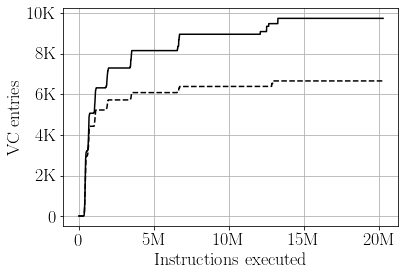

In [4]:
start=0
end=min(len(expsFT[0].data['ops']), len(expsFT[1].data['ops']))
fig, ax = plt.subplots()

ax.plot(expsFT[0].data['ops'][start:end], expsFT[0].data['locks']['vc total'][start:end], color='black')
ax.plot(expsFT[1].data['ops'][start:end], expsFT[1].data['locks']['vc total'][start:end], linestyle='--', color='black')
ax.set_ylabel('VC entries')
ax.set_xlabel('Instructions executed')
ax.grid()
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
xlabels = ['', '0', '5M', '10M', '15M', '20M']
_ = ax.set_xticklabels(xlabels)
ylabels = ['', '0', '2K', '4K', '6K', '8K', '10K']
_ = ax.set_yticklabels(ylabels)
plt.savefig("vcentries.pdf", bbox_inches='tight')